# Flow Testing Analysis Master Script

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
import os
import glob
import xarray as xr 
import matplotlib.ticker as ticker
import CoolProp.CoolProp as CP

### Choose Test and Data

In [ ]:
test_type = 'flowtest_12_7_24'
pattern = 'Orifice_Test'
# Define steady state start and end times for averages 
# Initialize as NaN if no steady state is known yet (put "= float('nan')" )
'''

'''
# start_seconds = float('nan')
# end_seconds = float('nan')

steady_state_ranges = {
    "Orifice_Test1": (20, 30),  # Start and stop indices for steady state
    "Orifice_Test2": (20, 30),
    "Orifice_Test3": (10, 30),
    "Orifice_Test4": (10, 25),  
    "Orifice_Test5": (20, 35),  
    "Orifice_Test6": (20, 45),  
    "Orifice_Test7": (18, 30),  
    "Orifice_Test8": (20, 35),  
    "Orifice_Test9": (20, 40),  
}

### Load Data

In [10]:
Data_Folder = f"./clean_data/{test_type}/"
Sensor_Defiinitions_csv = f"./clean_data/{test_type}/SensorDefinitions_{test_type}.csv"

label_csv = pd.read_csv(Sensor_Defiinitions_csv)
sensor_channels = list(label_csv["Sensor Physical Channel "])
sensor_mapping = label_csv.set_index("Sensor Physical Channel ").to_dict(orient="index")
keep_cols = sensor_channels + ["# Time"]
                               
def read_clean_data(pattern):
    files = glob.glob(f"{Data_Folder}/{pattern}*.csv") 
    if not files:
        print("No files found")
        return {}
    
    data_dfs = {}
    for file in files:
        print(f"Reading {file}")
        df = pd.read_csv(file)
        df = df[[c for c in df.columns if c in keep_cols]]
        data_dfs[os.path.basename(file)] = df

    return data_dfs

def scale_and_rename(data_dfs):
    for key, df in data_dfs.items():
        for col_name in df.columns:
            if col_name != "# Time" and col_name != "Time (s)":
                try:
                    scaling_info = sensor_mapping.get(col_name)
                    if scaling_info:
                        scaling_eq = scaling_info["Scaling Equation"]
                        sensor_name = scaling_info["Sensor Name "]
                        
                        x = np.array(df[col_name].values)
                        scaled_values = eval(scaling_eq)
                        df[col_name] = scaled_values
                        
                        df.rename(columns={col_name: sensor_name}, inplace=True)
                    else:
                        print(f"{col_name} does not have scaling Equation or name")
                except Exception as e:
                    print(f"Error processing column {col_name}: {e}")
    return data_dfs

def add_time_column(data_dfs):
    for key, df in data_dfs.items():
        start_time = df.at[df.index[0], '# Time']
        end_time = df.at[df.index[-1], '# Time']
        sample_rate = len(df['# Time']) / (end_time - start_time)
        time_arr = np.linspace(0, (end_time - start_time), len(df['# Time']))  # Convert to seconds
        df["Time (s)"] = time_arr
        data_dfs[key] = df
    return data_dfs

# Read data for 
Data_dfs = read_clean_data("Orifice_Test")
Data_dfs = add_time_column(Data_dfs)
Data_dfs = scale_and_rename(Data_dfs)

# print data for each sensor in first key of dictionary
print(Data_dfs[list(Data_dfs.keys())[0]])

Reading ./clean_data/flowtest_12_7_24/Orifice_Test4_PT_12-07-2024_15-11-32.csv
Reading ./clean_data/flowtest_12_7_24/Orifice_Test1_PT_12-07-2024_14-38-32.csv
Reading ./clean_data/flowtest_12_7_24/Orifice_Test5_PT_12-07-2024_15-21-54.csv
Reading ./clean_data/flowtest_12_7_24/Orifice_Test7_PT_12-07-2024_15-45-42.csv
Reading ./clean_data/flowtest_12_7_24/Orifice_Test9_PT_12-07-2024_16-01-29.csv
Reading ./clean_data/flowtest_12_7_24/Orifice_Test2_PT_12-07-2024_14-48-56.csv
Reading ./clean_data/flowtest_12_7_24/Orifice_Test3_PT_12-07-2024_14-58-38.csv
Reading ./clean_data/flowtest_12_7_24/Orifice_Test8_PT_12-07-2024_15-53-47.csv
Reading ./clean_data/flowtest_12_7_24/Orifice_Test6_PT_12-07-2024_15-31-26.csv
             # Time  Flow Meter  Post Orifice PT  Pre Orifice PT   Time (s)
0      1.733609e+09    0.011670        -0.445059        0.055885   0.000000
1      1.733609e+09    0.011670        -0.291753        0.113170   0.001000
2      1.733609e+09    0.014296        -0.353452        0.408

### Plots of everything 

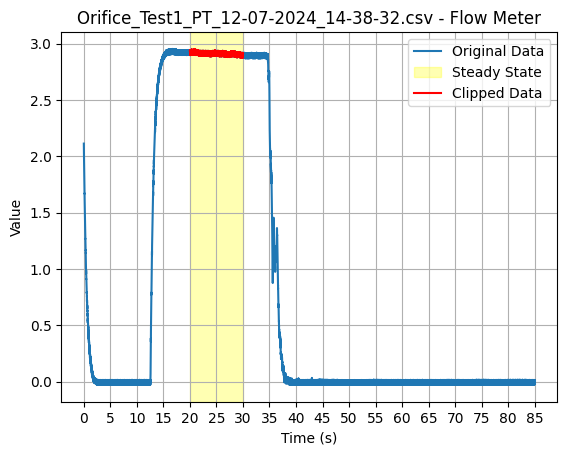

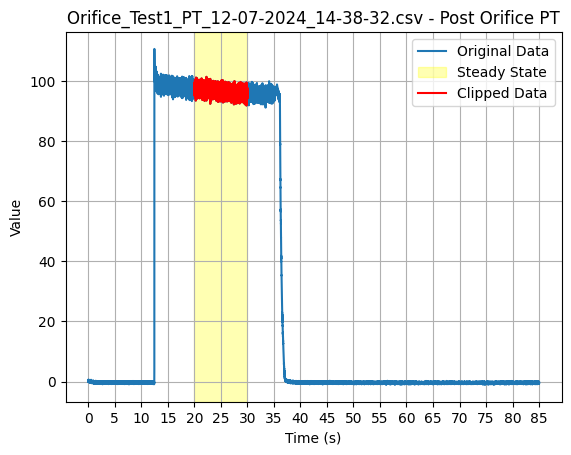

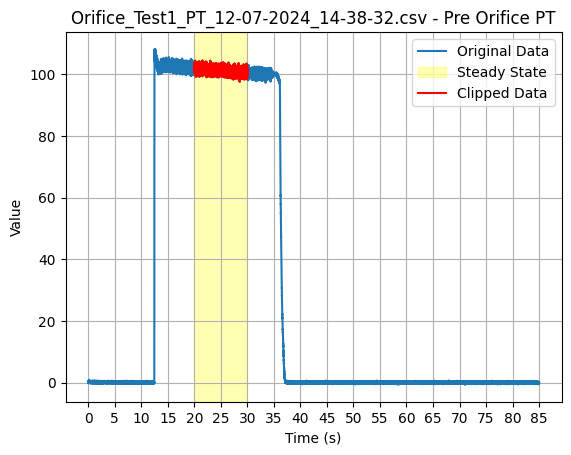

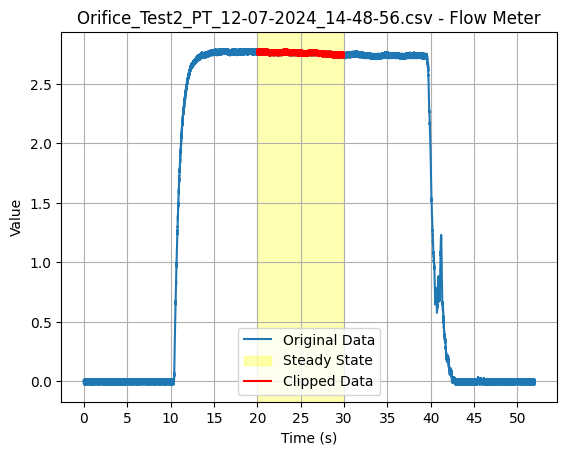

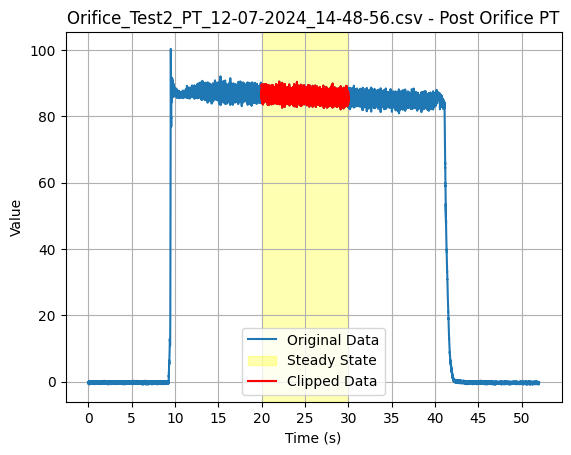

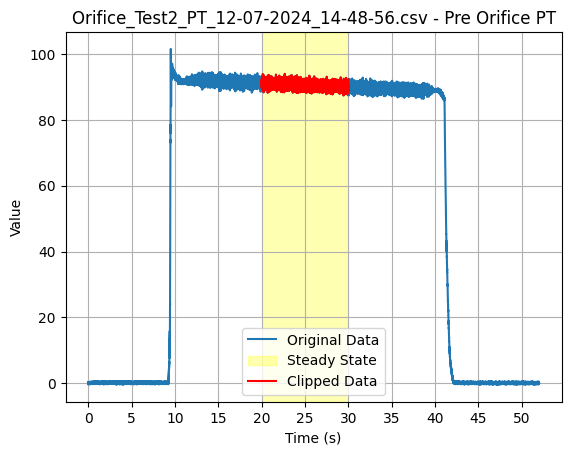

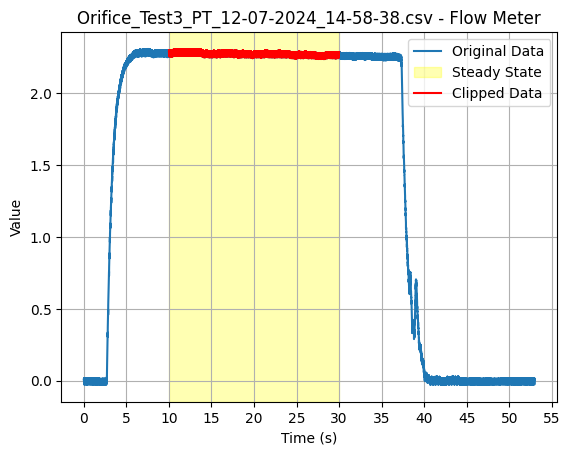

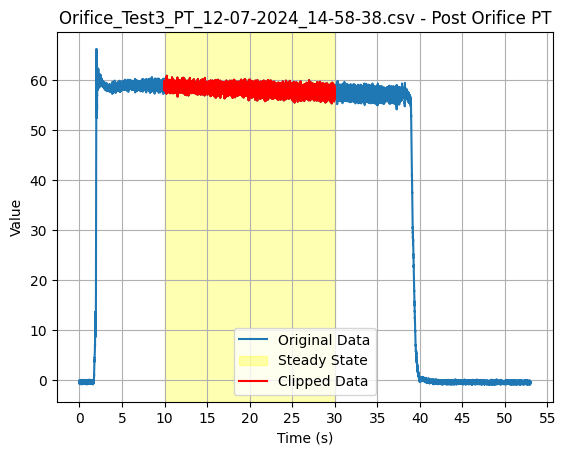

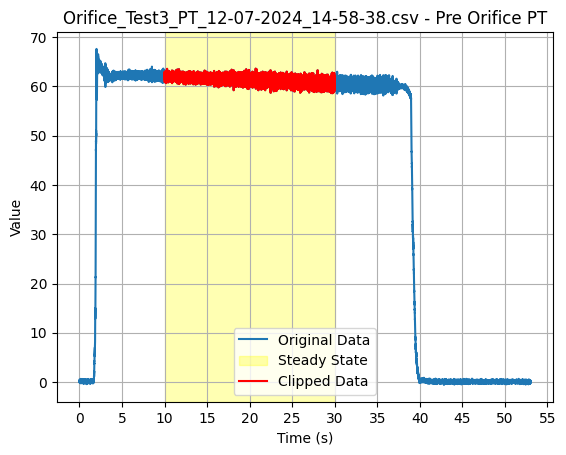

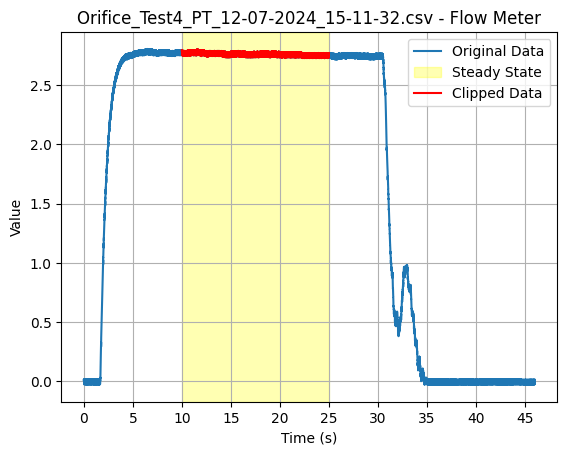

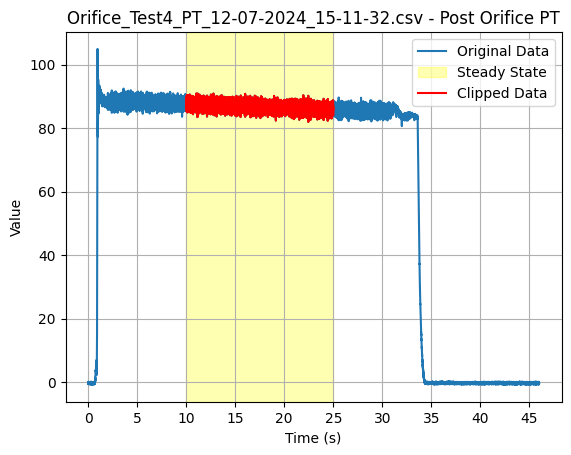

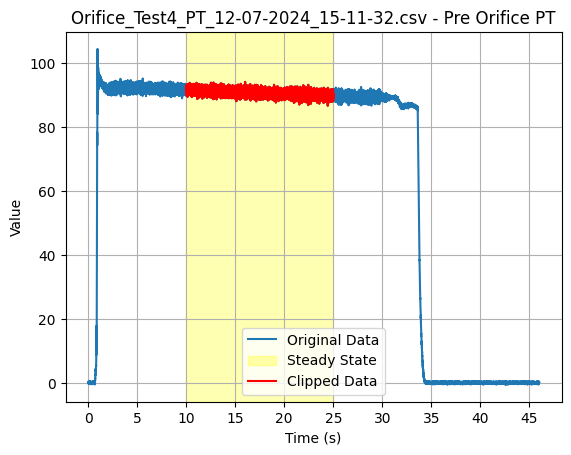

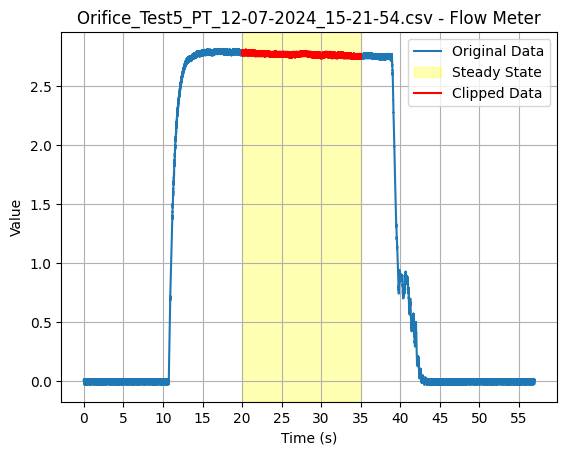

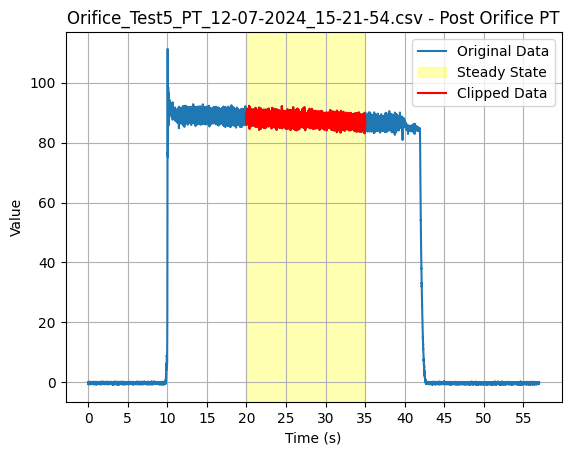

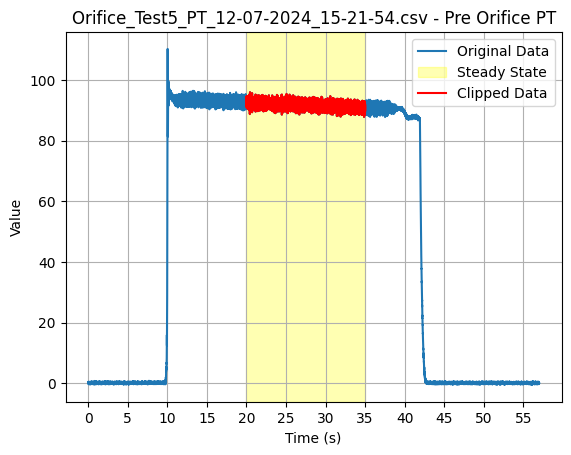

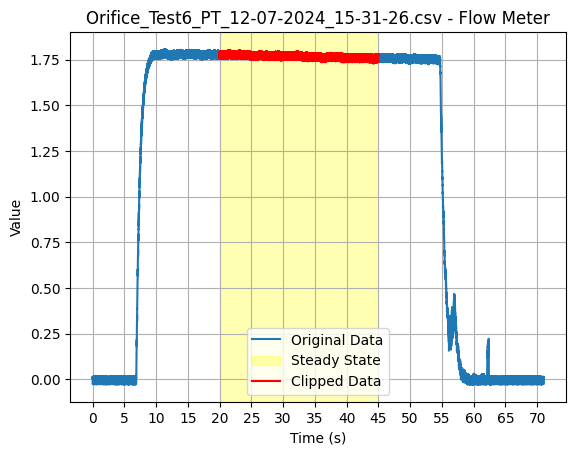

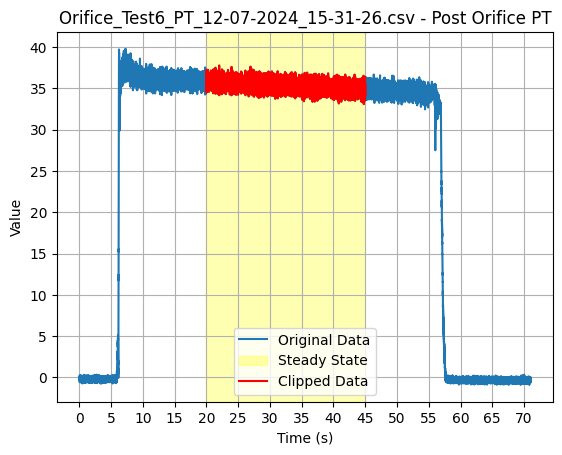

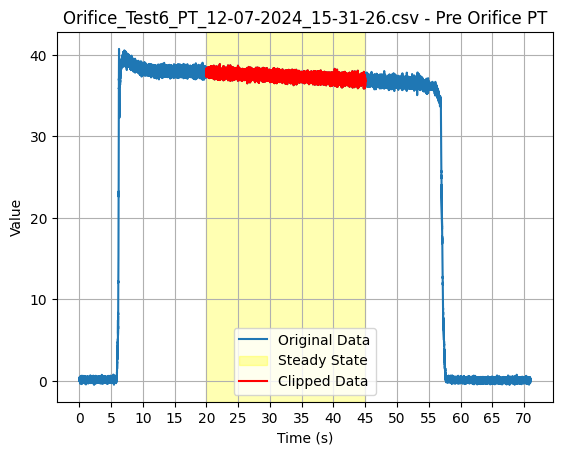

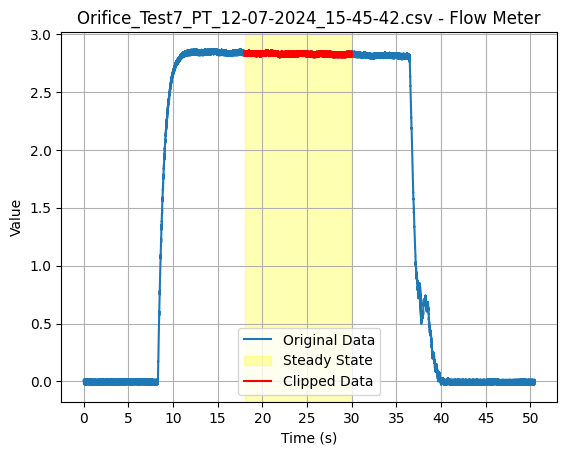

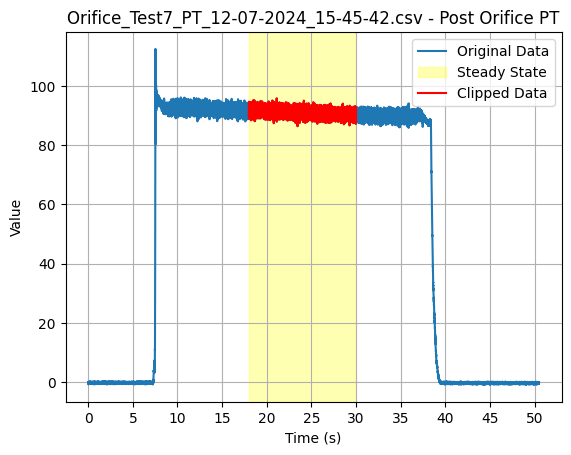

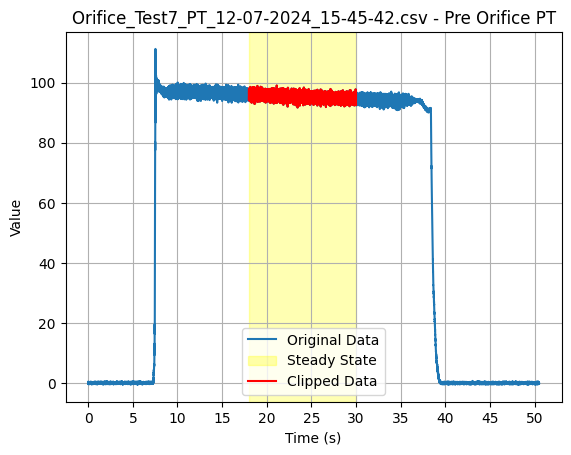

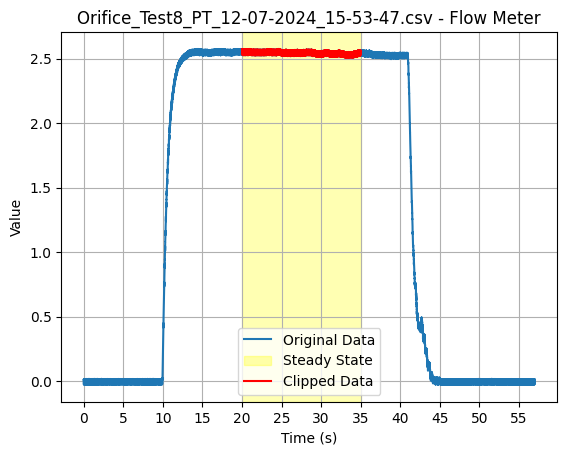

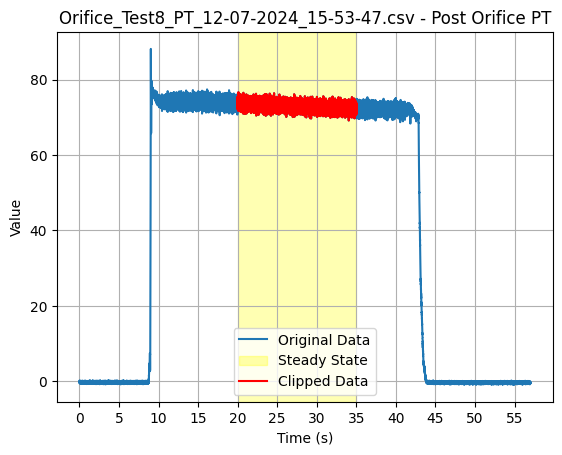

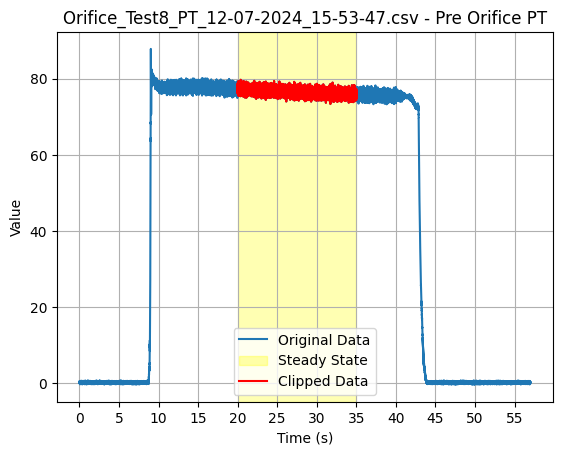

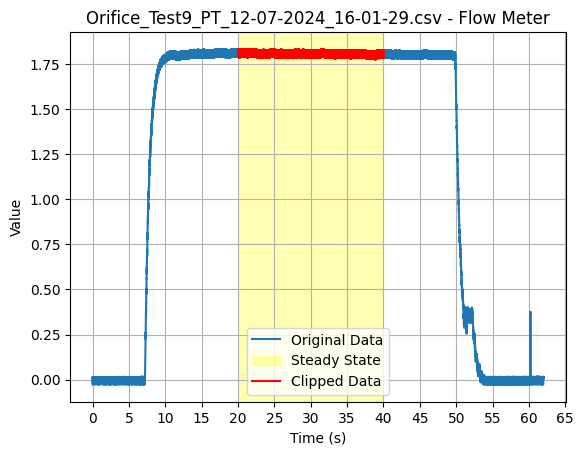

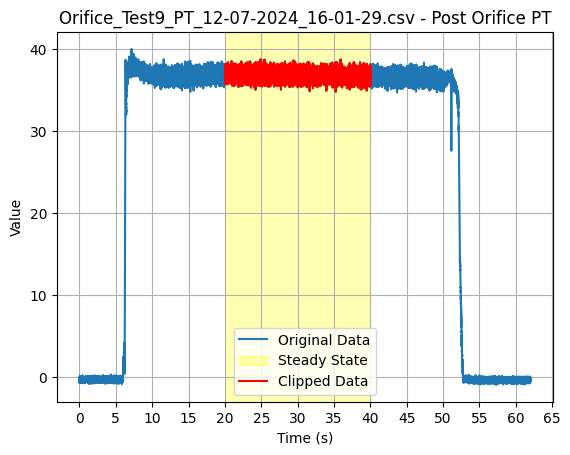

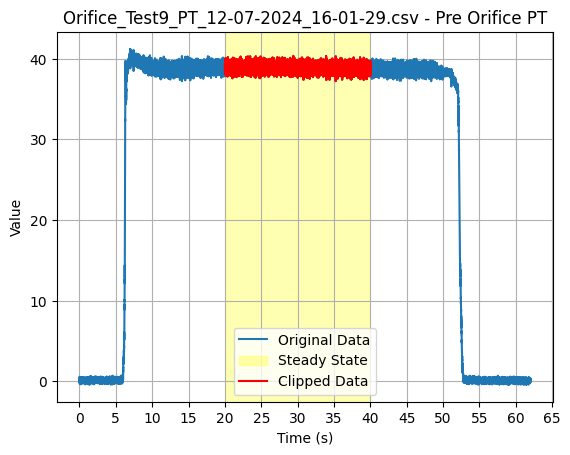

In [11]:
def clip_and_plot(data_dfs, steady_state_ranges):
    clipped_dfs = {}
    # output_folder = "./clipped_data/"
    # os.makedirs(output_folder, exist_ok=True)
    
    # Iterate over keys in steady_state_ranges and use glob to find matching files
    for test_name, (start, stop) in steady_state_ranges.items():
        matching_files = glob.glob(f"{Data_Folder}/{test_name}*.csv")
        if not matching_files:
            print(f"No files found for pattern: {test_name}")
            continue

        for file in matching_files:
            key = os.path.basename(file)
            if key not in data_dfs:
                print(f"{key} not in loaded DataFrames, skipping.")
                continue
            
            df = data_dfs[key]            
            # Clip data based on start and stop
            if start is None or stop is None:
                clipped_df = df  # Use entire DataFrame if no range is specified
            else:
                clipped_df = df[(df["Time (s)"] >= start) & (df["Time (s)"] <= stop)]
            
            clipped_dfs[key] = clipped_df

            # Plot each column with highlighted steady-state range
            data_df = df.drop(columns=["# Time", "Time (s)"])
            for col in data_df.columns:
                plt.figure()
                plt.plot(df["Time (s)"], df[col], label="Original Data")
                if start is not None and stop is not None:
                    plt.axvspan(start, stop, color="yellow", alpha=0.3, label="Steady State")
                    plt.plot(clipped_df["Time (s)"], clipped_df[col], label="Clipped Data", color="red")
                plt.title(f"{key} - {col}")
                plt.xlabel("Time (s)")
                plt.ylabel("Value")
                plt.grid()
                plt.legend()
                ax = plt.gca()
                ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
                plt.show()  
                # plt.savefig(f"{output_folder}{key}_{col}.png")
            # Save clipped DataFrame for further analysis
            # clipped_df.to_csv(f"{output_folder}{key}_clipped.csv", index=False)
    
    return clipped_dfs

# Call the function to process files
Clipped_dfs = clip_and_plot(Data_dfs, steady_state_ranges)


### Orifice Calc Stats

In [12]:

def gpm_to_mdot(gpm):
    gpm_to_m3s = gpm * 0.00378541 / 60.0
    density = CP.PropsSI('D', 'T', 294.15, 'P', 101325, 'Water')
    mdot = gpm_to_m3s * density
    return mdot

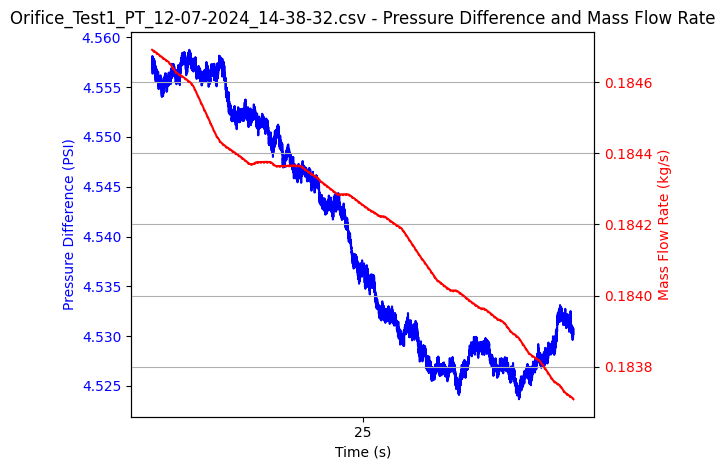

Orifice_Test1_PT_12-07-2024_14-38-32.csv: 
 Average Cd: 0.4781 
 Average Cv: 1.3893 
 Average Pressure Difference: 4.5411 psi


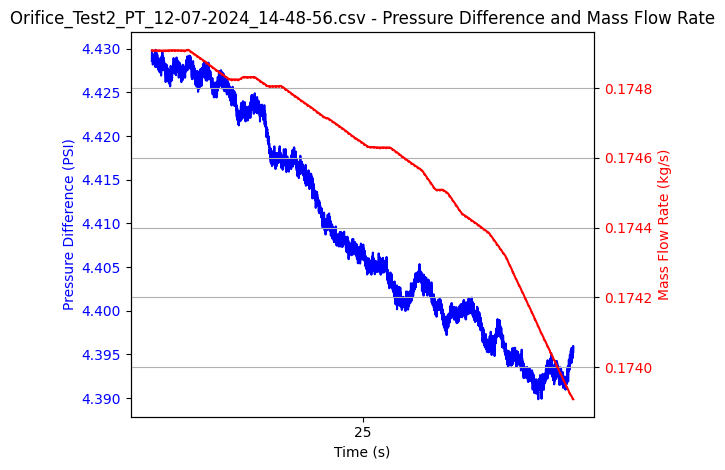

Orifice_Test2_PT_12-07-2024_14-48-56.csv: 
 Average Cd: 0.4632 
 Average Cv: 1.3461 
 Average Pressure Difference: 4.4098 psi


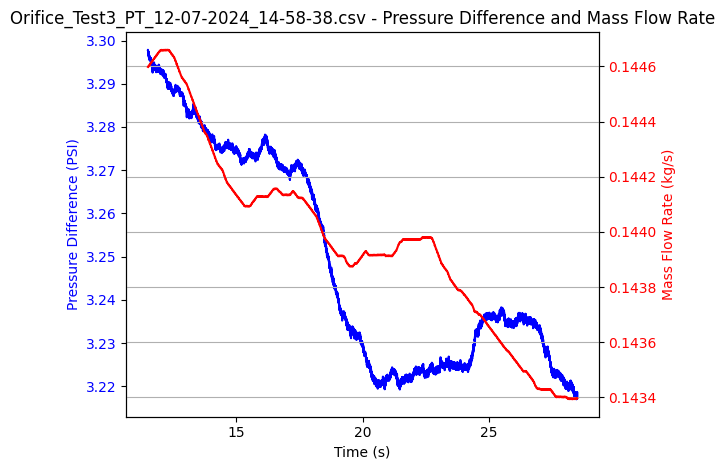

Orifice_Test3_PT_12-07-2024_14-58-38.csv: 
 Average Cd: 0.4424 
 Average Cv: 1.2855 
 Average Pressure Difference: 3.2504 psi


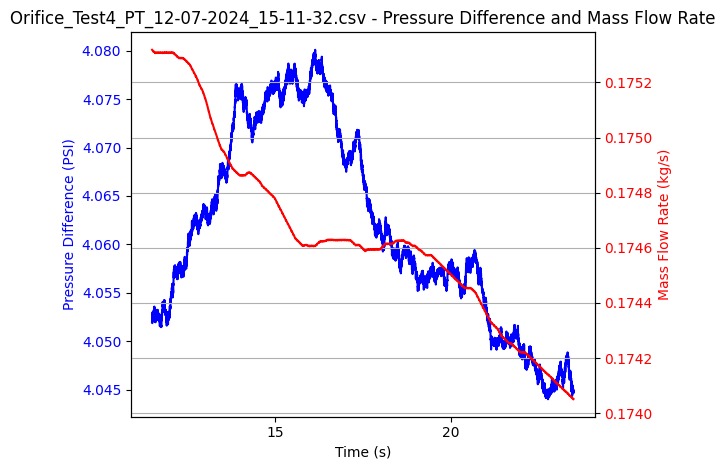

Orifice_Test4_PT_12-07-2024_15-11-32.csv: 
 Average Cd: 0.4355 
 Average Cv: 1.3819 
 Average Pressure Difference: 4.0591 psi


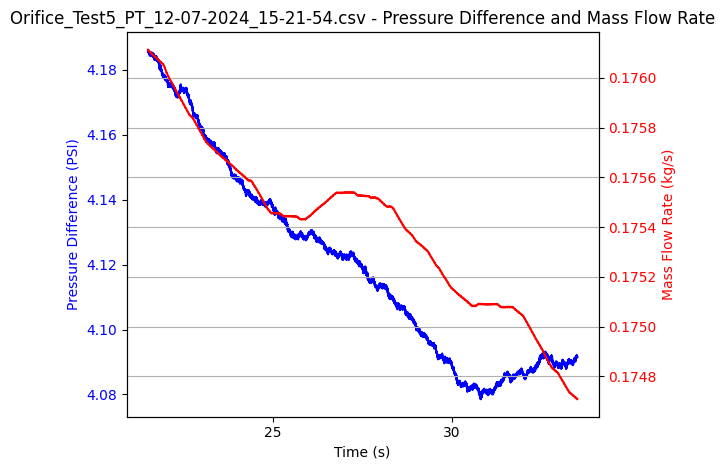

Orifice_Test5_PT_12-07-2024_15-21-54.csv: 
 Average Cd: 0.4367 
 Average Cv: 1.3855 
 Average Pressure Difference: 4.1236 psi


/Users/santiagoulloa/Desktop/RP_PROP/Analysis Scripts/propulsion_analysis/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/santiagoulloa/Desktop/RP_PROP/Analysis Scripts/propulsion_analysis/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


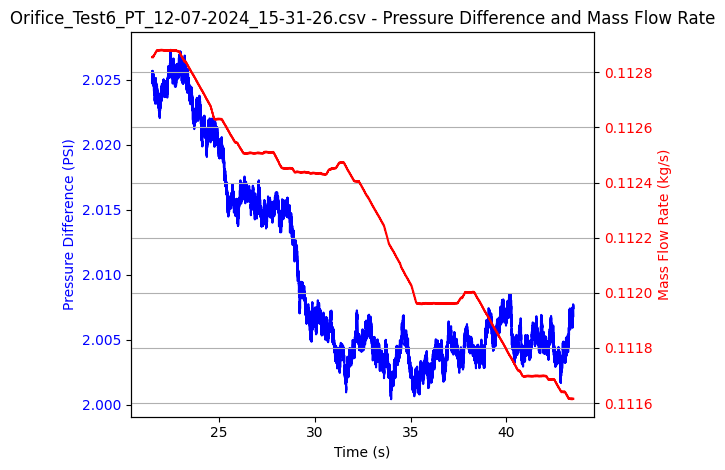

Orifice_Test6_PT_12-07-2024_15-31-26.csv: 
 Average Cd: 0.4075 
 Average Cv: 1.2928 
 Average Pressure Difference: 2.0105 psi


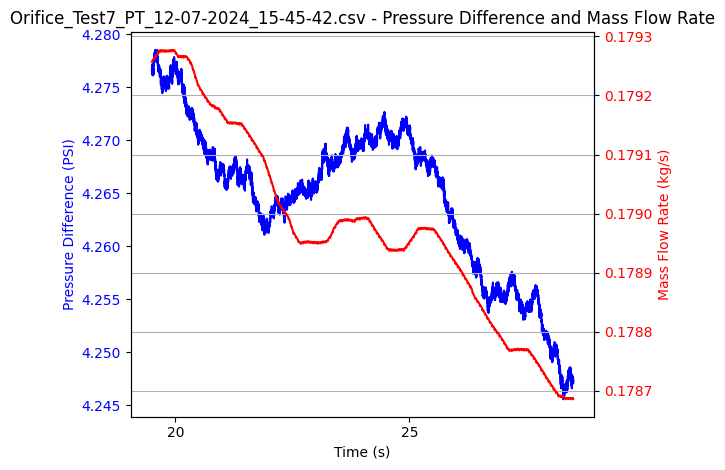

Orifice_Test7_PT_12-07-2024_15-45-42.csv: 
 Average Cd: 0.4259 
 Average Cv: 1.3847 
 Average Pressure Difference: 4.2642 psi


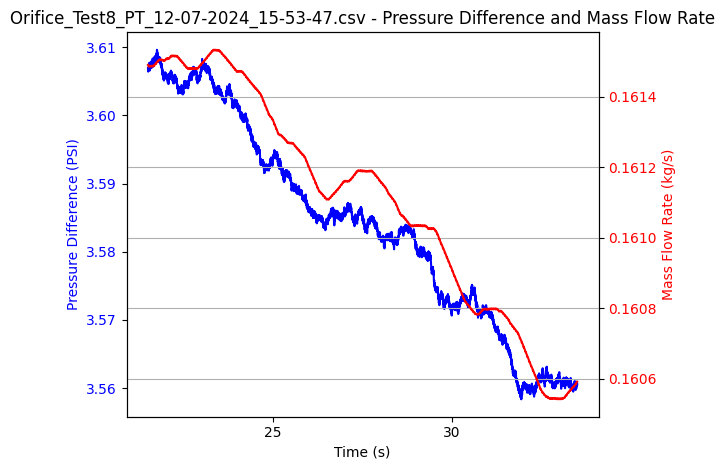

Orifice_Test8_PT_12-07-2024_15-53-47.csv: 
 Average Cd: 0.4172 
 Average Cv: 1.3562 
 Average Pressure Difference: 3.5841 psi


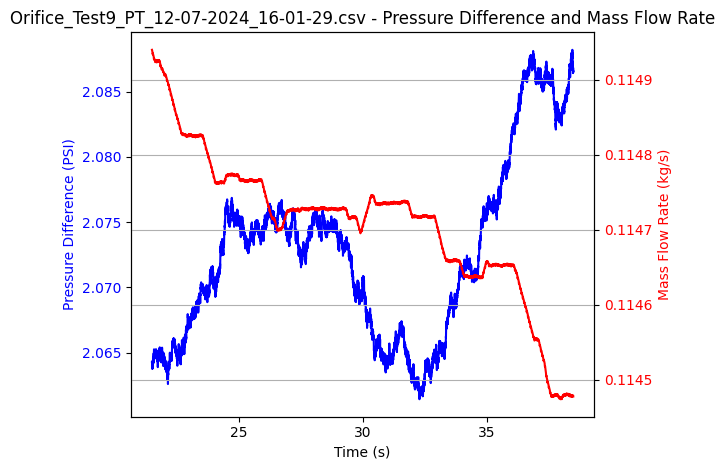

Orifice_Test9_PT_12-07-2024_16-01-29.csv: 
 Average Cd: 0.3911 
 Average Cv: 1.2715 
 Average Pressure Difference: 2.0731 psi


In [ ]:
orifice_diameters = {
    "Orifice_Test1": 0.312,  
    "Orifice_Test2": 0.312,
    "Orifice_Test3": 0.312,
    "Orifice_Test4": 0.326,  
    "Orifice_Test5": 0.326,  
    "Orifice_Test6": 0.326,  
    "Orifice_Test7": 0.330,  
    "Orifice_Test8": 0.330,  
    "Orifice_Test9": 0.330,  
}

# Define moving average function
def moving_average(data, window_size):
    return data.rolling(window=window_size, center=True).mean()

# Process and plot orifices
def process_and_plot_orifices(clipped_dfs, orifice_diameters, window_size=50):
    avg_cds = np.array([])
    avg_cvs = np.array([])
    avg_dps = np.array([])
    avg_mdots = np.array([])

    for test_name, (start, stop) in steady_state_ranges.items():
        matching_files = glob.glob(f"{Data_Folder}/{test_name}*.csv")
        if not matching_files:
            print(f"No files found for pattern: {test_name}")
            continue

        for file in matching_files:
            key = os.path.basename(file)
            if key not in clipped_dfs:
                print(f"No matching DataFrame for {key}, skipping.")
                continue

            df = clipped_dfs[key].copy()

            diameter = orifice_diameters.get(test_name, None)
            if diameter is None:
                print(f"No orifice diameter defined for {test_name}, skipping.")
                continue
            
            # Convert diameter to meters and calculate area
            diameter_m = diameter * 0.0254  # Convert inches to meters
            area = math.pi * (diameter_m / 2) ** 2

            # Calculate pressure difference (convert PSI to Pa)
            df.loc[:, "Pressure Difference (psi)"] = (df["Pre Orifice PT"] - df["Post Orifice PT"])
            df.loc[:, "Pressure Difference (Pa)"] = df["Pressure Difference (psi)"] * 6894.76

            # Convert Flow Meter GPM to Mass Flow Rate (kg/s)
            df.loc[:, "Mass Flow Rate (kg/s)"] = df["Flow Meter"].apply(gpm_to_mdot)

            # Density of water at ambient conditions
            density = CP.PropsSI('D', 'T', 294.15, 'P', 101325, 'Water') # kg/s

            # Calculate Cd and Cv
            df.loc[:, "Cd"] = df["Mass Flow Rate (kg/s)"] / (area * np.sqrt(2 * density * df["Pressure Difference (Pa)"]))
            df.loc[:, "Cv"] = df["Flow Meter"] / np.sqrt(df["Pressure Difference (psi)"] / 1)

            # Smooth the data using a moving average
            df.loc[:, "Smoothed Pressure Difference (psi)"] = moving_average(df["Pressure Difference (psi)"], window_size)
            df.loc[:, "Smoothed Mass Flow Rate (kg/s)"] = moving_average(df["Mass Flow Rate (kg/s)"], window_size)

            # Plot Pressure Difference and Mass Flow Rate
            fig, ax1 = plt.subplots()

            # Plot Smoothed Pressure Difference
            ax1.plot(df["Time (s)"], df["Smoothed Pressure Difference (psi)"], 'b-', label="Pressure Difference (PSI)")
            ax1.set_xlabel("Time (s)")
            ax1.set_ylabel("Pressure Difference (PSI)", color='b')
            ax1.tick_params(axis='y', labelcolor='b')
            ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))

            # Plot Smoothed Mass Flow Rate on Secondary Axis
            ax2 = ax1.twinx()
            ax2.plot(df["Time (s)"], df["Smoothed Mass Flow Rate (kg/s)"], 'r-', label="Mass Flow Rate")
            ax2.set_ylabel("Mass Flow Rate (kg/s)", color='r')
            ax2.tick_params(axis='y', labelcolor='r')
            
            plt.title(f"{key} - Pressure Difference and Mass Flow Rate")
            fig.tight_layout()
            plt.grid()
            plt.show()

            # Print Average Cd, Cv, and Pressure Difference
            avg_cd = df["Cd"].mean()
            avg_cv = df["Cv"].mean()
            avg_dp = df["Pressure Difference (psi)"].mean()

            print(f"{key}: \n Average Cd: {avg_cd:.4f} \n Average Cv: {avg_cv:.4f} \n Average Pressure Difference: {avg_dp:.4f} psi")
            avg_cds = np.append(avg_cds, avg_cd)
            avg_cvs = np.append(avg_cvs, avg_cv)
            avg_dps = np.append(avg_dps, avg_dp)
            avg_mdots = np.append(avg_mdots, df["Mass Flow Rate (kg/s)"].mean())

    return avg_cds, avg_cvs, avg_dps, avg_mdots

# Call the function to process files
avg_cds, avg_cvs, avg_dps, avg_mdots = process_and_plot_orifices(Clipped_dfs, orifice_diameters, window_size=3000)

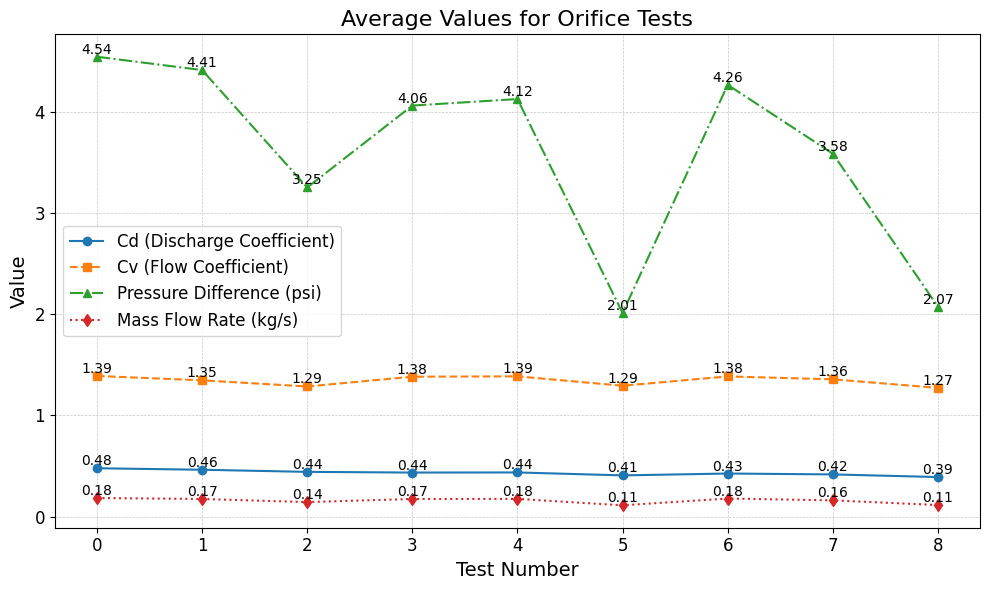

In [14]:
# Improved plot with annotations
plt.figure(figsize=(10, 6))
plt.plot(avg_cds, marker='o', linestyle='-', label="Cd (Discharge Coefficient)")
plt.plot(avg_cvs, marker='s', linestyle='--', label="Cv (Flow Coefficient)")
plt.plot(avg_dps, marker='^', linestyle='-.', label="Pressure Difference (psi)")
plt.plot(avg_mdots, marker='d', linestyle=':', label="Mass Flow Rate (kg/s)")

# Annotate each point with its value
for i, value in enumerate(avg_cds):
    plt.text(i, value, f"{value:.2f}", fontsize=10, ha='center', va='bottom')
for i, value in enumerate(avg_cvs):
    plt.text(i, value, f"{value:.2f}", fontsize=10, ha='center', va='bottom')
for i, value in enumerate(avg_dps):
    plt.text(i, value, f"{value:.2f}", fontsize=10, ha='center', va='bottom')
for i, value in enumerate(avg_mdots):
    plt.text(i, value, f"{value:.2f}", fontsize=10, ha='center', va='bottom')

plt.title("Average Values for Orifice Tests", fontsize=16)
plt.xlabel("Test Number", fontsize=14)
plt.ylabel("Value", fontsize=14)

plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc="best")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()
